对数据集进行分组并对各组应用一个函数（聚合或转换），十数据分析工作重要的环节。在将数据集加载、融合、准备好之后，通常就是计算分组统计或生成 透视表。

pandas有一个高效灵活的groupby功能，让你以自然的方式对数据集进行切片、切块、摘要等操作。

##### 复杂的分组运算：
 - 使用一个或多个键（形式可以是函数、数组、DataFrame列名）分割pandas对象。
 - 计算分组的概述统计，比如数量、平均值或标准差，用户定义的函数。
 - 应用组内转换或其他运算，如规格化、线型回归、排名或选取子集等。
 - 计算透视表或交叉表。
 - 执行分位数分析以及其他统计分组分析。

对时间序列数据的聚合（groupby的特殊用法之一）也称重采样（resampling），在之后讲解。

###  1.GroupBy机制

分组运算术语“split-apply-combibe”（拆分-应用-合并）。pandas对象中的数据会根据你所提供的一个或多个键被拆分（split）为多组。拆分操作是在对象的特定的轴上执行的（axis=0、1）。然后将一个函数应用（apply）到各个分组并产生一个新值。最后，所有这些函数的执行结果会被合并（combine）到最终的结果对象中。

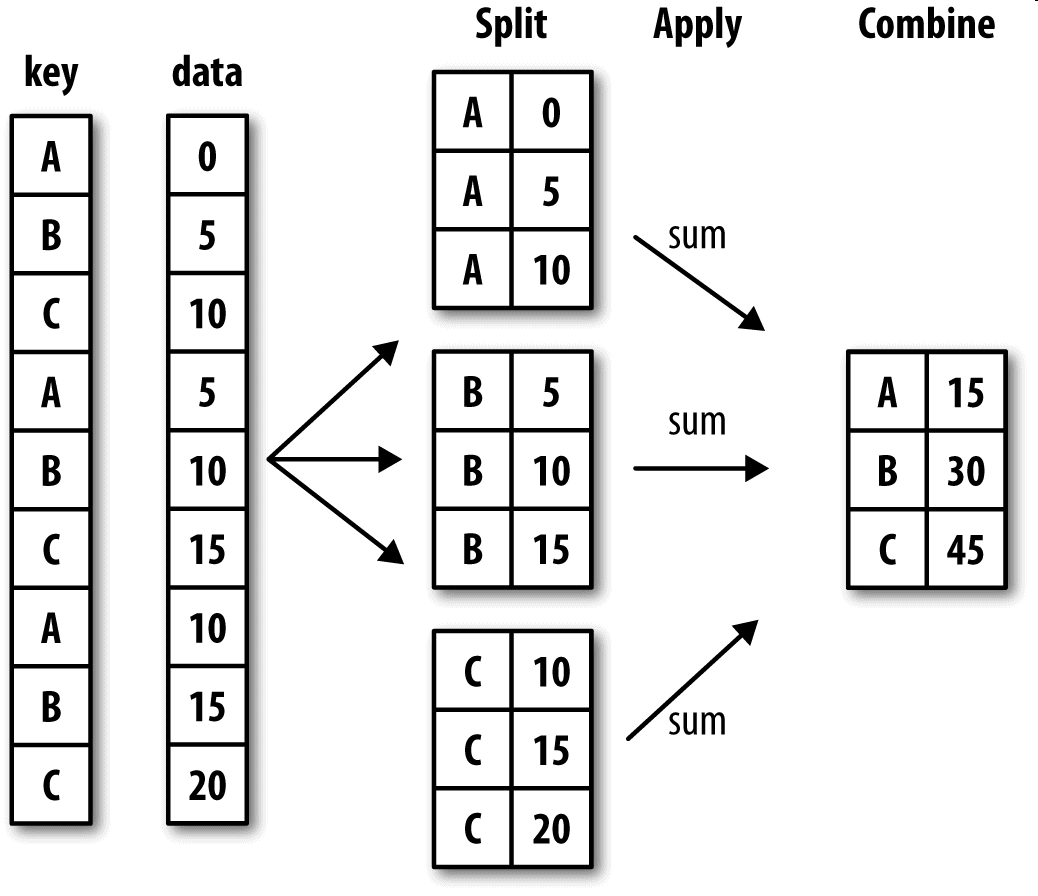

分组键可以有多种形式，且类型不必相同：
 - 列表或数组，其长度与待分组的轴一样。
 - 表示DAtaFrame某个列名的值。
 - 字典或Series，给出待分组轴上的值与分组名之间的对应关系。

In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.DataFrame({'key1': list('aabba'),
                  'key2': ['one', 'two', 'one', 'two', 'one'],
                  'data1': np.random.randn(5),
                  'data2': np.random.randn(5)})

In [6]:
df

,key1,key2,data1,data2
0,a,one,-1.470211,-0.910983
1,a,two,-0.589196,-0.529979
2,b,one,-0.472431,1.116380
3,b,two,1.209187,0.183240
4,a,one,1.461642,-1.301055


想要按key1进行分组，并计算data1列的平均值。

In [7]:
# 访问data1，并根据key1调用groupby
grouped = df['data1'].groupby(df['key1'])

In [8]:
grouped

##### 注意：

变量grouped是一个GroupBy对象。它实际上还没有进行任何计算，只是含有一些有关分组键df['key1']的中间数据而已。也就是该对象已经有了接下来对各组执行运算所需的一切信息。

In [9]:
# 例如，调用GroupBy的mean方法计算分组的平均值
grouped.mean()

key1
a   -0.199255
b    0.368378
Name: data1, dtype: float64

数据（Series）根据分组键进行了聚合，产生了一个新的series，其索引为key1列中的唯一值

In [15]:
# 一次传入多个数组的列表，得到不同的结果
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [16]:
means

key1  key2
a     one    -0.004284
      two    -0.589196
b     one    -0.472431
      two     1.209187
Name: data1, dtype: float64

In [17]:
means.unstack()

key2,one,two
key1,,
a,-0.004284,-0.589196
b,-0.472431,1.209187


In [20]:
# 在以上例子，分组键均是series，它可以是任何长度适当的数组
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
# 数组长度和行数相同

In [21]:
df['data1'].groupby([states, years]).mean()

California  2005   -0.589196
            2006   -0.472431
Ohio        2005   -0.130512
            2006    1.461642
Name: data1, dtype: float64

通常，分组信息就位于相同的要处理的DataFrame中。可以将列名（字符串、数字、其他Python对象）用作分组键：

In [22]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.199255,-0.914006
b,0.368378,0.649810


In [24]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one  -0.004284 -1.106019
     two  -0.589196 -0.529979
b    one  -0.472431  1.116380
     two   1.209187  0.183240

在执行df.groupby('key1').mean()时，结果中没有key2列。这是因为df['key2']不是数值数据（俗称“麻烦列”），所以从结果中排出。

GroupBy的size方法，返回一个含有分组大小的Series

In [25]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

In [26]:
df

,key1,key2,data1,data2
0,a,one,-1.470211,-0.910983
1,a,two,-0.589196,-0.529979
2,b,one,-0.472431,1.116380
3,b,two,1.209187,0.183240
4,a,one,1.461642,-1.301055


##### 注意：任何分组关键词中的缺失值，都会被从结果中除去。

#### 对分组进行迭代

GroupBy对象支持迭代，可以产生一组二元元组（由分组名和数据块组成）

In [31]:
for name, group in df.groupby('key1'):
    print(name)  # 分组名
    print("-" * 30)
    print(group)  # 数据块
    print("=" * 30)

a
------------------------------
  key1 key2     data1     data2
0    a  one -1.470211 -0.910983
1    a  two -0.589196 -0.529979
4    a  one  1.461642 -1.301055
b
------------------------------
  key1 key2     data1    data2
2    b  one -0.472431  1.11638
3    b  two  1.209187  0.18324


对于多重键的情况，元组的第一个元素将会是由键值组成的元组：

In [45]:
for t, group in df.groupby(['key1', 'key2']):
    print(t)
    print(group)
    print("=" * 30)  # 可以用 (k1, k1) 代替 t 使输出更直观

('a', 'one')
  key1 key2     data1     data2
0    a  one -1.470211 -0.910983
4    a  one  1.461642 -1.301055
('a', 'two')
  key1 key2     data1     data2
1    a  two -0.589196 -0.529979
('b', 'one')
  key1 key2     data1    data2
2    b  one -0.472431  1.11638
('b', 'two')
  key1 key2     data1    data2
3    b  two  1.209187  0.18324


将这些数据片段做成一个字典,先进行列表化

In [51]:
pieces = dict(list(df.groupby('key1')))

In [52]:
pieces['b']

,key1,key2,data1,data2
2,b,one,-0.472431,1.11638
3,b,two,1.209187,0.18324


groupby默认是在axis=0上进行分组的，通过设置让其在其他轴上进行分组。

In [54]:
df

,key1,key2,data1,data2
0,a,one,-1.470211,-0.910983
1,a,two,-0.589196,-0.529979
2,b,one,-0.472431,1.116380
3,b,two,1.209187,0.183240
4,a,one,1.461642,-1.301055


In [53]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [57]:
grouped = df.groupby(df.dtypes, axis=1)  # 按列的类型进行分组

In [58]:
for dtype, group in grouped:
    print(dtype)
    print(group)
    print("=" * 30)

float64
      data1     data2
0 -1.470211 -0.910983
1 -0.589196 -0.529979
2 -0.472431  1.116380
3  1.209187  0.183240
4  1.461642 -1.301055
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


#### 选取一列或列的子集

对于由DataFrame产生的GroupBy对象，如果用一个（单个字符串）或一组（字符串数组）列名对其进行索引，就能实现选取部分列进行聚合的目的。

In [ ]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

以下是代码的语法糖：

In [ ]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

尤其对于大数据集，很可能只需要对部分列进行聚合。例如，如果只需要计算data2列的平均值并以DataFrame形式返回，可以这样写：

In [70]:
df.groupby(['key1', 'key2'])[['data2']].mean()  # 返回DataFrame

data2
key1 key2          
a    one  -1.106019
     two  -0.529979
b    one   1.116380
     two   0.183240

这种索引操作返回的对象是一个已分组的DataFrame（如果传入的是列表或数组）或已分组的Series（如果传入的是标量形式的单个列名）

In [66]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

In [68]:
s_grouped

In [71]:
s_grouped.mean()  # 返回Series

key1  key2
a     one    -1.106019
      two    -0.529979
b     one     1.116380
      two     0.183240
Name: data2, dtype: float64

#### 通过字典或Series进行分组

除数组以外，分组信息还可以其他形式存在。

In [74]:
people = pd.DataFrame(np.random.randn(5, 5), columns=list('abcde'), 
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [75]:
people.iloc[2:3, [1, 2]] = np.nan  # 添加缺失值
people

,a,b,c,d,e
Joe,-0.376389,-0.186506,0.481798,-1.031352,0.567048
Steve,-0.901355,-0.805844,-1.341661,-0.539262,0.063150
Wes,-0.322479,NaN,NaN,0.759481,-0.133678
Jim,0.794442,-2.955428,-0.619321,1.116011,1.498172
Travis,1.492020,-0.251018,-0.163699,1.478175,0.327002


假设已知列的分组关系，并希望根据分组计算列的和：

In [76]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

将这个字典传给groupby，来构造数组，我们可以直接传递字典（我包含了键“f”来说明，可以存在未使用的分组键“f”）

In [77]:
by_column = people.groupby(mapping, axis=1)

In [78]:
by_column.sum()

,blue,red
Joe,-0.549554,0.004154
Steve,-1.880923,-1.644048
Wes,0.759481,-0.456157
Jim,0.496690,-0.662814
Travis,1.314476,1.568003


Series也有同样的功能，它可以被看做一个固定大小的映射：

In [81]:
map_series = pd.Series(mapping)  # 将字典变为series
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [84]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


上面将series当做分组键传入和字典传入效果一样

#### 通过函数进行分组

和字典或series相比，使用Python函数是一种更为原生的方法定义分组映射。任何被当做分组键的函数都会在各个索引值上被调用一次，其返回值就会被用作分组名称。

In [85]:
people

,a,b,c,d,e
Joe,-0.376389,-0.186506,0.481798,-1.031352,0.567048
Steve,-0.901355,-0.805844,-1.341661,-0.539262,0.063150
Wes,-0.322479,NaN,NaN,0.759481,-0.133678
Jim,0.794442,-2.955428,-0.619321,1.116011,1.498172
Travis,1.492020,-0.251018,-0.163699,1.478175,0.327002


以这个DF为例，其索引值为人名，可以计算一个字符串长度的数组，更为简单的方法是传入len函数

In [87]:
people.groupby(len).sum()  # 按人名长度分组

,a,b,c,d,e
3,0.095575,-3.141933,-0.137523,0.844140,1.931542
5,-0.901355,-0.805844,-1.341661,-0.539262,0.063150
6,1.492020,-0.251018,-0.163699,1.478175,0.327002


将函数跟数组、列表、字典、Series混合使用也不是问题，因为任何东西在内部都会被转换为数组

In [90]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [92]:
people.groupby([len, key_list]).min()  # 按人名长度和给出列表进行分组

a         b         c         d         e
3 one -0.376389 -0.186506  0.481798 -1.031352 -0.133678
  two  0.794442 -2.955428 -0.619321  1.116011  1.498172
5 one -0.901355 -0.805844 -1.341661 -0.539262  0.063150
6 two  1.492020 -0.251018 -0.163699  1.478175  0.327002

#### 根据索引级别分组

层次化索引数据集最方便的地方就在于它能够根据轴索引的一个级别进行聚合

In [94]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],[1, 3, 5, 1, 3]], names=['cty', 'tenor'])

In [96]:
# 在列上进行层次化索引
hire_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hire_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.854395 -1.138860  0.537030  0.016494 -0.354875
1      0.372558 -0.512152 -0.001367  1.367305 -0.291407
2     -0.017602  0.288548 -0.081320 -0.048455  0.434568
3      0.028062  1.810569  1.765646 -0.429965  0.935175

要根据级别分组，使用level关键字传递级别序列号或名字

In [97]:
hire_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


###  2.数据聚合

聚合指的是任何能够从数组产生标量值的数据转换过程。比如mean、count、min以及sum等。你可能想知道GroupBy对象调用mean()时发生了什么。许多常见的聚合运算都有进行优化。

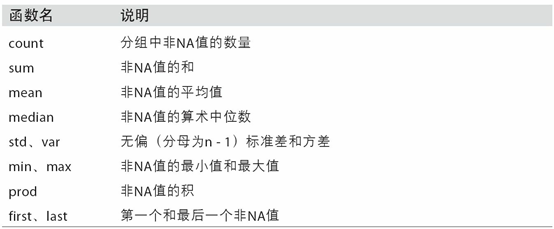

你可以自己发明聚合运算，还可以调用分组对象上已定义好的任何方法。例如，quantile可以计算Series或DataFrame列的样本分位数。

虽然quantile并没有明确地实现于GroupBy，但它是一个Series方法，所以这里是能用的。GroupBy会高效的对Series进行切片，然后对各片调用piece.quantile(0.9)，最后将这些结果组装成最终结果。

In [98]:
df

,key1,key2,data1,data2
0,a,one,-1.470211,-0.910983
1,a,two,-0.589196,-0.529979
2,b,one,-0.472431,1.116380
3,b,two,1.209187,0.183240
4,a,one,1.461642,-1.301055


In [99]:
grouped = df.groupby('key1')

In [101]:
grouped['data1'].quantile(0.9)

key1
a    1.051474
b    1.041025
Name: data1, dtype: float64

如果要使用你自己的聚合函数，只需将其传入aggregate或agg方法即可：

In [103]:
def peak_to_prak(arr):
    """返回数组的最大值减去最小值"""
    return arr.max() - arr.min()

In [104]:
grouped.agg(peak_to_prak)

,data1,data2
key1,,
a,2.931853,0.771076
b,1.681618,0.933140


有些方法（如describe）也可以用在这里，严格来讲，他们并非聚合运算

In [105]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0 -0.199255  1.504321 -1.470211 -1.029703 -0.589196  0.436223   
b      2.0  0.368378  1.189083 -0.472431 -0.052026  0.368378  0.788782   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.461642   3.0 -0.914006  0.385547 -1.301055 -1.106019 -0.910983   
b     1.209187   2.0  0.649810  0.659829  0.183240  0.416525  0.649810   

                          
           75%       max  
key1                      
a    -0.720481 -0.529979  
b     0.883095  1.116380

自定义聚合函数比经过优化的函数要慢很多，因为在构造中间分组数据块时存在非常大的开销（函数调用、数据重排）

#### 面向列的多函数应用

In [5]:
tips = pd.read_csv("tips.csv")

In [6]:
# 添加小费占总费用的百分比
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [136]:
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


对Series或DataFrame列的聚合运算其实就是使用aggregate（自定义函数）或调用诸如mean、std之类的方法

你可能希望对不同的列使用不同的聚合函数，或一次应用多个函数。

In [111]:
grouped = tips.groupby(['day', 'smoker'])

In [112]:
# 对tip_pct列进行分组键操作
grouped_pct = grouped['tip_pct']

In [116]:
grouped_pct.count()

day   smoker
Fri   No         4
      Yes       15
Sat   No        45
      Yes       42
Sun   No        57
      Yes       19
Thur  No        45
      Yes       17
Name: tip_pct, dtype: int64

In [115]:
grouped_pct.agg('mean')  # 同grouped_pct.mean()

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

如果传入一组函数或函数名，得到的DataFrame的列就会以相应的函数命名：

In [119]:
grouped_pct.agg(['mean', 'std', peak_to_prak])

mean       std  peak_to_prak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

并非一定要接受GroupBy自动给出的那些列名，特别是lambda函数。传入由（name，function）元组组成的列表，则各元组的第一个元素就会被用作DataFrame的列名（可以将这种二元元组列表看做一个有序映射）

In [120]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

对于DataFrame，你可以定义一组应用于全部列的一组函数，或不同的列应用不同的函数。

In [122]:
# 对tip_pct和total_bill列计算三个统计信息
functions = ['count', 'mean', 'max']

In [127]:
grouped.count()  # grouped是已经按day、smoker分组

total_bill  tip  time  size  tip_pct
day  smoker                                      
Fri  No               4    4     4     4        4
     Yes             15   15    15    15       15
Sat  No              45   45    45    45       45
     Yes             42   42    42    42       42
Sun  No              57   57    57    57       57
     Yes             19   19    19    19       19
Thur No              45   45    45    45       45
     Yes             17   17    17    17       17

In [124]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

In [125]:
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

如你所见，结果的DataFrame拥有层次化的列，这相当于分别对各列进行聚合，然后用concat将结果组装到一起，使用列名用作keys参数

In [129]:
result['tip_pct']  # 选择小费占比列

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

In [130]:
# 传入带有自定义名称的一组元组,平均水平和偏差
ftuples = [('Durchschbitt', 'mean'), ('Abweichung', np.std)]

In [131]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill           
            Durchschbitt Abweichung Durchschbitt Abweichung
day  smoker                                                
Fri  No         0.151650   0.028123    18.420000   5.059282
     Yes        0.174783   0.051293    16.813333   9.086388
Sat  No         0.158048   0.039767    19.661778   8.939181
     Yes        0.147906   0.061375    21.276667  10.069138
Sun  No         0.160113   0.042347    20.506667   8.130189
     Yes        0.187250   0.154134    24.120000  10.442511
Thur No         0.160298   0.038774    17.113111   7.721728
     Yes        0.163863   0.039389    19.190588   8.355149

假设想对一个列或不同的列应用不同函数。具体方法是向agg传入一个从列名映射到函数的字典

In [133]:
grouped.agg({'tip': np.max, 'size': 'sum'})  # tip列和size列

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [135]:
grouped.agg({'tip_pct': ['min', 'max', 'mean', 'std'],
            'size': 'sum'})
# 对tip_pct列应用不同的函数

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

只有将多个函数应用到至少一列时，DataFrame才会拥有层次化的列

#### 以“没有行索引”的形式返回数据聚合

到目前为止，所有实例中的聚合数据都有由唯一的分组键组成的索引（可能还是层次化的）。由于并不总是需要如此，可以向groupby出入as_index=False禁用该功能。

In [137]:
tips.groupby(['day', 'smoker']).mean()

total_bill       tip      size   tip_pct
day  smoker                                          
Fri  No       18.420000  2.812500  2.250000  0.151650
     Yes      16.813333  2.714000  2.066667  0.174783
Sat  No       19.661778  3.102889  2.555556  0.158048
     Yes      21.276667  2.875476  2.476190  0.147906
Sun  No       20.506667  3.167895  2.929825  0.160113
     Yes      24.120000  3.516842  2.578947  0.187250
Thur No       17.113111  2.673778  2.488889  0.160298
     Yes      19.190588  3.030000  2.352941  0.163863

In [138]:
# 禁用层次化索引功能
tips.groupby(['day', 'smoker'], as_index=False).mean() 

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


### 3.apply：一般性的“拆分-应用-合并”

最通用的GroupBy方法是apply。apply会将待处理的对象拆分成多个片段，然后对各片段调用传入的函数，最后尝试将各片段组合到一起。

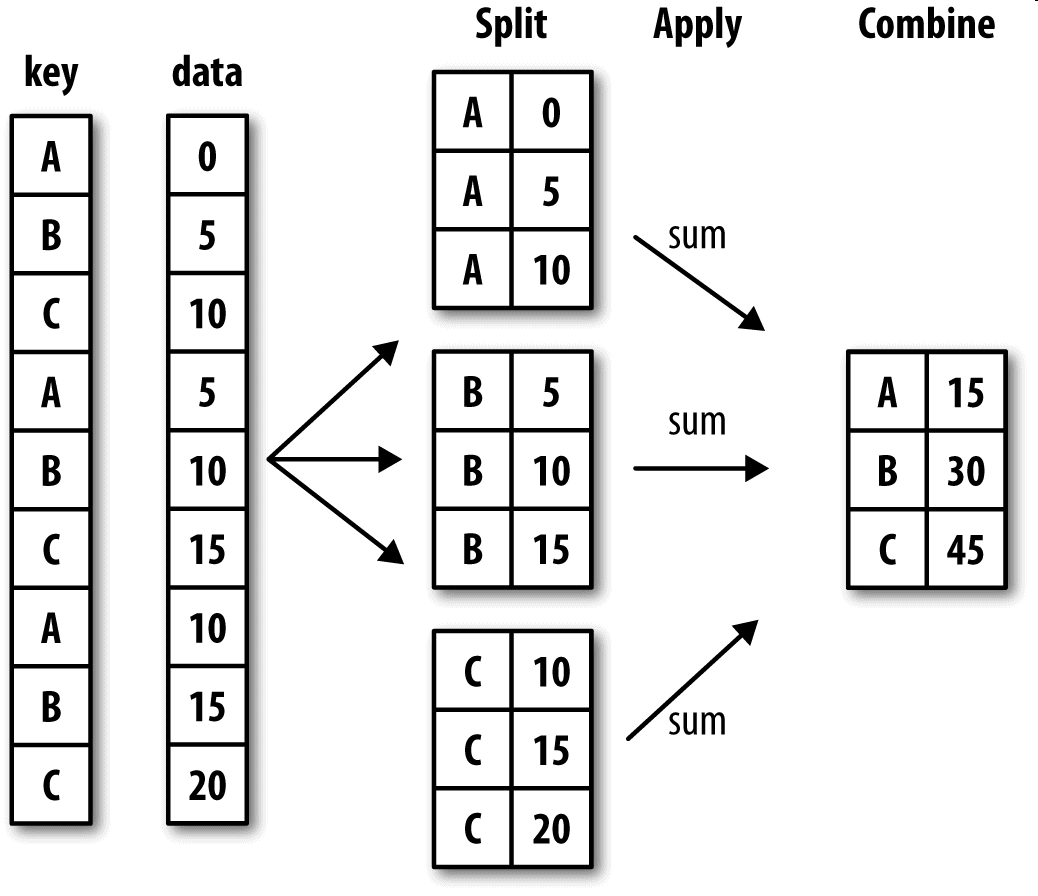

In [142]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


回到之前那个小费数据集，假设你想要根据分组选出最高的5个tip_pct值。

In [147]:
# 定义一个选取指定列具有最大值的行的函数
def top(df, n=5, column='tip_pct'):
    # 返回将指定列从大到小排序后的前n行
    return df.sort_values(by=column, ascending=False)[:n]

In [148]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
232,11.61,3.39,No,Sat,Dinner,2,0.291990
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525


如果对smoker分组并用apply调用该函数，得到：

In [159]:
tips.groupby('smoker').apply(top)  #是否是smoker按tip_pct从高到低的前5行

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     232       11.61  3.39     No   Sat  Dinner     2  0.291990
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       88        24.71  5.85     No  Thur   Lunch     2  0.236746
Yes    172        7.25  5.15    Yes   Sun  Dinner     2  0.710345
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       109       14.31  4.00    Yes   Sat  Dinner     2  0.279525

top函数在DataFrame的各个片段上调用，结果由pandas.concat组装到一起，并以分组名称进行了标记。于是最终结果就有了一个层次化索引，其内层索引值来自原DataFrame。

如果传给apply的函数能够接受其他参数或关键字，则可以将这些内容放在函数名后面一并传入：

In [161]:
# apply调用函数所需要的参数放在函数名后面
tips.groupby(['smoker', 'day']).apply(top, n=2, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
            91        22.49   3.50     No   Fri  Dinner     2  0.155625
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
            59        48.27   6.73     No   Sat  Dinner     4  0.139424
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
            112       38.07   4.00     No   Sun  Dinner     3  0.105070
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
            85        34.83   5.17     No  Thur   Lunch     4  0.148435
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
            90        28.97   3.00    Yes   Fri  Dinner     2  0.103555
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
            102       44.30   2.50    Yes   Sat  Dinner     3  0.056433
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
            184       40.55   3.00    Yes   Sun  Dinner     2  0.073983
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982
            83        32.68   5.00    Yes  Thur   Lunch     2  0.152999

In [162]:
# 在GroupBy对象上调用果describe
result = tips.groupby('smoker')['tip_pct'].describe()

In [163]:
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [164]:
result.unstack()

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

In [ ]:
调用describe之类的方法，等价于：
f = lambda x: x.describe()
groupby.apply(f)

#### 禁止分组键

分组键会跟原始对象的索引共同构成结果对象中的层次化索引。将groupby_keys=False传入给groupby可禁止该效果：

In [166]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
232,11.61,3.39,No,Sat,Dinner,2,0.291990
149,7.51,2.00,No,Thur,Lunch,2,0.266312
51,10.29,2.60,No,Sun,Dinner,2,0.252672
185,20.69,5.00,No,Sun,Dinner,5,0.241663
88,24.71,5.85,No,Thur,Lunch,2,0.236746
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525


In [167]:
tips.groupby('smoker').apply(top)  # 未禁用效果

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     232       11.61  3.39     No   Sat  Dinner     2  0.291990
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       88        24.71  5.85     No  Thur   Lunch     2  0.236746
Yes    172        7.25  5.15    Yes   Sun  Dinner     2  0.710345
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       109       14.31  4.00    Yes   Sat  Dinner     2  0.279525

#### 分位数和桶分析

pandas有一些能根据指定面元或样本分位数将数据拆分为多块的工具（比如cut、qcut）。将这些函数跟groupby结合起来，就能非常轻松的实现对数据集的桶（bucket）或分位数（quantile）分析了。

In [3]:
# 以下面简单的随机数据集为例，利用cut将其装入长度相等的桶（bucket）中
frame = pd.DataFrame({'data1': np.random.randn(1000), 'data2': np.random.randn(1000)})

In [6]:
frame.head()

,data1,data2
0,0.454496,-0.656632
1,-0.629031,3.724794
2,1.815104,0.378863
3,-2.263789,-0.116852
4,-0.637721,0.139168


In [4]:
# 四分位数
quartiles = pd.cut(frame.data1, 4)

In [10]:
quartiles[:10]

0     (-0.111, 1.383]
1    (-1.604, -0.111]
2      (1.383, 2.876]
3    (-3.104, -1.604]
4    (-1.604, -0.111]
5      (1.383, 2.876]
6    (-1.604, -0.111]
7    (-1.604, -0.111]
8    (-3.104, -1.604]
9     (-0.111, 1.383]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.104, -1.604] < (-1.604, -0.111] < (-0.111, 1.383] < (1.383, 2.876]]

由cut返回的对象Categorical对象可直接传递到groupby。

In [12]:
# 对data2列做一些统计计算
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(),
           'mean': group.mean()}

In [13]:
grouped = frame.data2.groupby(quartiles)

In [16]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.104, -1.604]",54.0,3.172585,0.016915,-1.973071
"(-1.604, -0.111]",449.0,3.724794,0.019364,-3.185897
"(-0.111, 1.383]",426.0,2.734337,-0.010542,-2.508656
"(1.383, 2.876]",71.0,1.648942,-0.080160,-1.684450


以上都是长度相等的桶。要根据样本分位数得到大小相等的桶，使用qcut即可。传入labels=False即可只获取分位数的编号

In [44]:
# 返回八分位数,且只显示分位数编号
grouping = pd.qcut(frame.data1, 8, labels=False)

In [41]:
grouping.head()

0    5
1    2
2    7
3    0
4    2
Name: data1, dtype: int64

In [42]:
grouped = frame.data2.groupby(grouping)

In [43]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,125.0,3.172585,-0.015391,-3.009213
1,125.0,2.217933,-0.003700,-2.813150
2,125.0,3.724794,0.077285,-3.185897
3,125.0,2.290593,0.021200,-2.592691
4,125.0,2.734337,-0.010656,-2.419831
5,125.0,2.607098,0.105817,-2.165461
6,125.0,2.348917,0.048805,-2.508656
7,125.0,1.648942,-0.227957,-2.051258


#### 示例：用特定于分组的值填充缺失值

对于缺失值，有时你会用dropna将其替换掉，而有时可能希望用一个固定的值或由数据本身所衍生出来的值取填充NA。则用到fillna这个工具

In [45]:
s = pd.Series(np.random.randn(6))

In [48]:
s[::2] = np.nan 

In [47]:
s

0         NaN
1    0.336549
2         NaN
3    0.784207
4         NaN
5   -0.479695
dtype: float64

In [50]:
s.fillna(s.mean())  # 用数据的平均值填充缺失值

0    0.213687
1    0.336549
2    0.213687
3    0.784207
4    0.213687
5   -0.479695
dtype: float64

假设你要对不同的分组填充不同的值。一种方法是将数据分组，并使用apply和一个能对各数据块调用fillna的函数即可。

In [51]:
# 有关美国几个州的示例数据，这些州又被分位东西部
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']

In [55]:
# 生成分组键列表，东西各四个
group_key = ['East'] * 4 + ['West'] * 4
group_key

['East', 'East', 'East', 'East', 'West', 'West', 'West', 'West']

In [53]:
data = pd.Series(np.random.randn(8), index=states)

In [54]:
data

Ohio         -0.421529
New York     -1.838064
Vermont       0.657399
Florida      -0.046302
Oregon        1.832692
Nevada        0.695615
California   -1.085925
Idaho        -1.199240
dtype: float64

In [59]:
data[['Vermont', 'Nevada', 'Nevada', 'Idaho']] = np.nan
data

Ohio         -0.421529
New York     -1.838064
Vermont            NaN
Florida      -0.046302
Oregon        1.832692
Nevada             NaN
California   -1.085925
Idaho              NaN
dtype: float64

In [62]:
data.groupby(group_key).mean()

East   -0.768632
West    0.373383
dtype: float64

In [64]:
# 用分组的平均值去填充NA值
fill_mean = lambda x: x.fillna(x.mean())

In [65]:
data.groupby(group_key).apply(fill_mean)

Ohio         -0.421529
New York     -1.838064
Vermont      -0.768632
Florida      -0.046302
Oregon        1.832692
Nevada        0.373383
California   -1.085925
Idaho         0.373383
dtype: float64

另外，也可以在代码中预定义各组的填充值。由于分组具有一个name属性，拿过来用一下

In [66]:
fill_values = {'East': 0.5, 'West': -1}

In [67]:
fill_func = lambda x: x.fillna(fill_values[x.name])

In [71]:
data.groupby(group_key).apply(fill_func)

Ohio         -0.421529
New York     -1.838064
Vermont       0.500000
Florida      -0.046302
Oregon        1.832692
Nevada       -1.000000
California   -1.085925
Idaho        -1.000000
dtype: float64

#### 示例：随机采样和排列

假设你想要从一个大数据集中随机抽取（进行替换或部替换）样本以进行蒙特卡罗模拟（Monte Carlo simulation）或其他分析工作。“抽取”的方式由很多，这里是对Series使用sample方法：

In [72]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = list()
for suit in suits:
    cards.extend(str(num) + suit for num in base_names)
    
deck = pd.Series(card_val, index=cards)

现在有了一个长度为52的Series，其索引包括牌名，值则是21点 或其他游戏中用于计分的点数（当A的点数为1）：

In [73]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [80]:
# 从整副牌中随机抽取5张
def draw(deck, n=5):
    return deck.sample(n)

In [81]:
draw(deck)

8S      8
JD     10
2S      2
KS     10
10H    10
dtype: int64

假设你想要从 每种花色中随机抽取两张牌。由于花色是牌名的最后一个字符，所以据此进行分组，并使用apply：

In [83]:
get_suit = lambda card: card[-1]

In [84]:
deck.groupby(get_suit).apply(draw, n=2)

C  6C     6
   5C     5
D  QD    10
   3D     3
H  QH    10
   KH    10
S  JS    10
   4S     4
dtype: int64

In [85]:
# 或者这样写：
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

2C     2
AC     1
3D     3
AD     1
2H     2
JH    10
6S     6
KS    10
dtype: int64

#### 示例：分组加权平均数和相关系数

根据groupby的“拆分-应用-合并”范式，可以进行DataFrame的列与列之间或两个Series之间的运算（比如分组加权平均）。以下面这个数据集为例，它含有分组键、值以及一些权重：

In [86]:
df = pd.DataFrame({'category': list('aaaabbbb'), 'data': np.random.randn(8), 
                  'weights': np.random.rand(8)})

In [87]:
df

,category,data,weights
0,a,1.528903,0.596829
1,a,2.233111,0.715992
2,a,2.136672,0.255745
3,a,-0.352166,0.934931
4,b,0.146152,0.982569
5,b,-0.509054,0.847829
6,b,-1.013553,0.500229
7,b,1.405481,0.404702


In [88]:
# 利用category计算分组加权平均数
grouped = df.groupby('category')

In [89]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [93]:
grouped.apply(get_wavg)  # 对分组后的数据进行加权平均

category
a    1.089905
b   -0.082694
dtype: float64

In [95]:
grouped.mean()['data']  # 直接求平均值

category
a    1.386630
b    0.007257
Name: data, dtype: float64

考虑一个来自Yahoo！Finance的数据集，其中包含了几只股票和标准普尔500指数（符号SPX）的收盘价：

In [98]:
close_px = pd.read_csv('/home/mason/Date-Analysis-with-python/examples/stock_px_2.csv', parse_dates=True, index_col=0)

In [101]:
close_px.info()  # 数据集的基本信息

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [99]:
close_px.head()

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


一个比较有趣的任务：计算一个由日收益率（通过百分数变化计算）与SPX之间的年度相关系数组成的DataFrame。

In [107]:
# 创建匿名函数，计算每列和SPX列的成对相关系数
spx_corr = lambda x: x.corrwith(x['SPX'])

In [117]:
# 使用pct_change计算close_px的百分比变化,下一行相对于上一行的百分比变化
rets = close_px.pct_change().dropna()

In [121]:
rets.head()

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09,0.008242,0.029094,0.021159,0.019386


In [109]:
# 用年对百分比变化进行分组，可以用一个一行的函数，
# 从每行的标签返回每个datetime标签的year属性
get_year = lambda x: x.year
by_year = rets.groupby(get_year)

In [113]:
by_year.count()

,AAPL,MSFT,XOM,SPX
2003,251,251,251,251
2004,252,252,252,252
2005,252,252,252,252
2006,251,251,251,251
2007,251,251,251,251
2008,253,253,253,253
2009,252,252,252,252
2010,252,252,252,252
2011,199,199,199,199


In [110]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [123]:
# 计算列与列之间的相关系数。比如Apple和Microsoft的年相关系数
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

#### 示例：组级别的线性回归

顺着上一个例子，你可以用groupby执行更为复杂的分组统计分析，只要函数返回的是pandas对象或标量值即可。

例如，我们可以定义下面这个regress函数（利用statsmodels计量经济学库）对各数据块执行普通的最小二乘法回归：

In [129]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    y = data[yvar]
    x = data[xvars]
    x['intercept'] = 1
    result = sm.OLS(y, x).fit()
    return result.params

In [132]:
# 现在，为了按年计算AAPL对SPX收益率的现行回归，执行：
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


### 4.透视表和交叉表

透视表（pivot table）是各种电子表格程序和其他数据分析软件中一种常见的数据汇总工具。它根据一个或多个键对数据进行聚合，并根据行和列上的分组建将数据非配到各个矩形区域中。通过groupby功能以及（能够利用层次化索引的）重塑运算制作透视表。

DataFrame有一个pivot_table方法，还有一个顶级的pandas.pivot_table函数。pivot_table还可以添加分项小计，也叫margins

回到小费数据集，假设我想要根据day和smoker计算分组平均数（povit_table的默认聚合类型），并将day和smoker放到行上：

In [138]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [137]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

用groupby直接来做。假设我们只想聚合tip_pct和size，而且想根据time进行分组，将smoker放到列上，把day放到行上：

In [139]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

还可以对这个表进一步处理，传入margin=True添加分项小计。这将会添加标签为All的行和列，其值对应单个登记中所有数据的分组统计

In [141]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker',
                margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

这里，All值为平均数：不单独考虑烟民与非烟民（All列），不单独分组两个级别中的任何单项（All行）

要是用其他的聚合函数，将其传给aggfunc即可。

In [1]:
# 使用count或ken可以得到有关分组大小的交叉表（计数或频率）
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day', aggfunc=len, margin=True)

NameError: name 'tips' is not defined

#### 交叉表：pivot table

#### 交叉表：crosstab